# photometry_plot.ipynb

開口測光したデータをプロットする。横軸は衛星のSys3経度。

In [127]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import pandas as pd
import os
import copy
import ftpS3
import localtime
import spiceypy as spice
spice.furnsh('kernel/cassMetaK.txt')

fontname = 'Nimbus Sans'
plt.rcParams.update({'font.sans-serif': fontname,
                    'font.family': 'sans-serif',
                     'mathtext.fontset': 'custom',
                     'mathtext.rm': fontname,
                     'mathtext.it': fontname+':italic',
                     # 'mathtext.bf': 'Nimbus Sans:italic:bold',
                     'mathtext.bf': fontname+':bold'
                     })


# cpalette = ['#8ecae6', '#ffb703', '#023047', '#fb8500', '#219ebc']
cpalette = ['#0F4C81', '#FF6F61', '#645394',
         '#84BD00', '#F6BE00', '#F7CAC9', '#0F80E6']
cpalette = ['#184678', '#005261', '#C00000', '#E88B00', '#F25A00', '#2F397D', '#A3BDDA', '#9FC0B4', '#F3B5A8', '#EECA77', '#EFA785', '#AAACD4']
cpalette = ['#E7534B', '#EF8C46', '#F7D702', '#3C8867', '#649CDB', '#5341A5', '#A65FAC', '#A2AAAD']

# Color universal design
cud4 = ['#FF3300', '#FFF100', '#03AF7A', '#005AFF', '#4DC4FF', '#FF8082', '#F6AA00', '#990099', '#804000']
cud4bs = ['#FFCABF', '#FFFF80', '#D8F255', '#BFE4FF', '#FFCA80', '#77D9A8', '#C9ACE6', '#84919E']

In [128]:
# Set legend shadow
def legend_shadow(fig, ax, legend, dx, dy):

  frame = legend.get_window_extent()

  xmin, ymin = fig.transFigure.inverted().transform((frame.xmin, frame.ymin))
  xmax, ymax = fig.transFigure.inverted().transform((frame.xmax, frame.ymax))

  # plot patch shadow
  rect = patches.Rectangle((xmin+dx, ymin+dy), xmax-xmin, ymax-ymin, 
                          transform=fig.transFigure,
                          edgecolor='k', facecolor='k',
                          clip_on=False)
  ax.add_patch(rect)

  return None

In [129]:
north_doy = ['14/006_v06', '14/013_v13', '14/016_v12', '22/271_v18', '22/274_v17']
south_doy = ['22/185_v09', '22/310_v19', '22/349_v23']
south_doy = ['22/185_v09', '22/185_v09_MAW']

nbkg_doy = ['14/001_v01', '14/002_v02', '14/005_v05', '14/006_v06', '14/013_v13', '14/016_v12', '22/185_v10', '22/228_v13', '22/271_v18', '22/274_v17', '22/309_v20', '22/349_v24']
sbkg_doy = ['22/140_v03', '22/185_v09', '22/186_v11', '22/229_v14', '22/310_v19', '22/311_v21', '22/349_v23']

def load(csvname0):
    df = pd.read_csv(csvname0, sep='\t')
    utc = df.loc[:, 'date']                                 # UTC date
    efplat = df.loc[:, 'lat [deg]'].values                  # EFP latitude [deg]
    efpwlong = df.loc[:, 'wlong [deg]'].values              # EFP System III longitude [deg]
    moons3 = df.loc[:, 'Moon S3 [deg]'].values              # Europa's System III longitude [deg]
    final_phot_ave = df.loc[:, 'spot brightness [kR]']      # EFP brightness [kR]
    annulus_median = df.loc[:, 'local background [kR]']     # local background [kR]
    
    b0_arr = np.zeros(len(final_phot_ave))
    b1_arr = np.zeros(len(final_phot_ave))
    efplat0_arr = np.zeros(len(final_phot_ave))
    efpwlong0_arr = np.zeros(len(final_phot_ave))
    moons30_arr = np.zeros(len(final_phot_ave))
    for i in range(len(final_phot_ave)):
        if final_phot_ave[i] != '0':
            b0_arr[i] = final_phot_ave[i]
            b1_arr[i] = annulus_median[i]
            efplat0_arr[i] = efplat[i]
            efpwlong0_arr[i] = efpwlong[i]
            moons30_arr[i] = moons3[i]
        else:
            continue
    
    return utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr

JRM33計算結果

磁気赤道面crossingのSys3 [deg] 110.61452513966482

磁場成分 Br 最大のSys3 [deg] 189.05027932960894

磁気赤道面crossingのSys3 [deg] 281.56424581005587

### 横軸: EuropaのS3経度

EFPの明るさ

In [130]:
hem = 'North'
if hem == 'North':
    doy = north_doy
    bkgdoy = nbkg_doy
    bon17 = '0006'
elif hem == 'South':
    doy = south_doy
    bkgdoy = sbkg_doy
    bon17 = '0007'
else:
    doy = north_doy+south_doy
    bkgdoy = nbkg_doy+sbkg_doy

refnum = 0
if hem == 'South':
    refnum = 1
satoval = np.recfromtxt('ref/2021je007055-sup-000'+str(3+refnum)+'-table si-s0'+str(2+refnum)+'.txt', skip_header=3,
                names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])

xing_s3wlon_110 = ftpS3.ftpS3().FPW(110.61452513966482, satoval, 'EUROPA')
xing_s3wlon_290 = ftpS3.ftpS3().FPW(110.61452513966482+180, satoval, 'EUROPA')

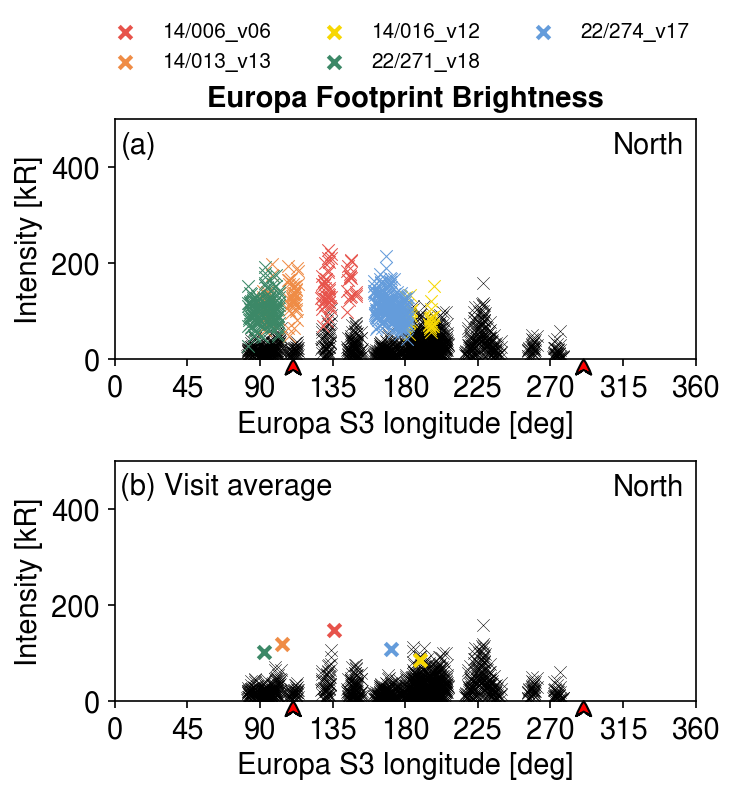

In [131]:
# ----- 1枚目のパネル -----
fontsize = 14
fig, ax = plt.subplots(2,1, figsize=(5,5.5), dpi=150)
ax[0].set_title('Europa Footprint Brightness', weight='bold', fontsize=fontsize)
ax[0].set_xlim(0,360)
ax[0].set_ylim(0,500)
# ax.set_yticks(np.linspace(-10,200,5))
# ax.set_yticklabels(np.linspace(-10,200,5))
ax[0].set_xticks(np.linspace(0,360,9))
ax[0].set_xticklabels(np.linspace(0,360,9, dtype=int))
ax[0].set_xlabel('Europa S3 longitude [deg]', fontsize=fontsize)
ax[0].set_ylabel('Intensity [kR]', fontsize=fontsize)
ax[0].tick_params(axis='x', labelsize=fontsize)
ax[0].tick_params(axis='y', labelsize=fontsize)
ax[0].text(0.01, 0.95, '(a)', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize)
ax[0].text(0.98, 0.95, hem, color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize)
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'   # Footprint aurora brightness
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(moons30_arr, b0_arr, marker='x', c=cpalette[i], linewidths=0.5, label=doy[i], zorder=1)
for i in range(len(bkgdoy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+bkgdoy[i]+'/brightness.csv'         # Brightness at the model spot
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(moons30_arr, b0_arr, marker='x', c='#000000', linewidths=0.25, zorder=0.8)
# ax[0].axvline(x=110.61452513966482, color='#cfcfcf', zorder=0.5)
# ax[0].axvline(x=110.61452513966482+180, color='#cfcfcf', zorder=0.5)


# ----- 2枚目のパネル -----
# ax[1].set_title('Europa Footprint Brightness ('+hem+')', weight='bold', fontsize=fontsize)
ax[1].set_xlim(0,360)
ax[1].set_ylim(0,500)
# ax.set_yticks(np.linspace(-10,200,5))
# ax.set_yticklabels(np.linspace(-10,200,5))
ax[1].set_xticks(np.linspace(0,360,9))
ax[1].set_xticklabels(np.linspace(0,360,9, dtype=int))
ax[1].set_xlabel('Europa S3 longitude [deg]', fontsize=fontsize)
ax[1].set_ylabel('Intensity [kR]', fontsize=fontsize)
ax[1].tick_params(axis='x', labelsize=fontsize)
ax[1].tick_params(axis='y', labelsize=fontsize)
ax[1].text(0.01, 0.95, '(b) Visit average', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize)
ax[1].text(0.98, 0.95, hem, color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize)
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_ave = np.average(efplat0_arr[idx])
    efpwlong0_ave = np.average(efpwlong0_arr[idx])
    moons30_ave = np.average(moons30_arr[idx])
    b0_ave = np.average(b0_arr[idx])
    b1_ave = np.average(b1_arr[idx])
    ax[1].scatter(moons30_ave, b0_ave, marker='x', c=cpalette[i], linewidths=2, label=doy[i], zorder=1)
for i in range(len(bkgdoy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+bkgdoy[i]+'/brightness.csv'         # Brightness at the model spot
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[1].scatter(moons30_arr, b0_arr, marker='x', c='#000000', linewidths=0.25, zorder=0.8)
# ax[1].axvline(x=110.61452513966482, color='#cfcfcf', zorder=0.5)
# ax[1].axvline(x=110.61452513966482+180, color='#cfcfcf', zorder=0.5)


for j in range(1):
    # obtain the handles and labels from the figure
    handles, labels = ax[j].get_legend_handles_labels()
    # copy the handles
    handles = [copy.copy(ha) for ha in handles ]
    # set the linewidths to the copies
    [ha.set_linewidth(2) for ha in handles ]
    ax[j].legend(handles=handles,
                 labels=labels,
                 loc='center left',
                 bbox_to_anchor=(-0.05, 1.3),
                 ncol=3,
                 frameon=False)

for i in range(2):
    ax[0].annotate('',
                xy=(110.61452513966482+180*i, 0), xycoords='data',
                xytext=(110.61452513966482+180*i, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))
    ax[1].annotate('',
                xy=(110.61452513966482+180*i, 0), xycoords='data',
                xytext=(110.61452513966482+180*i, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))


fig.tight_layout()
plt.show()

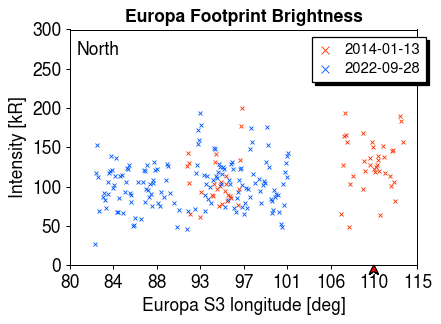

In [132]:
# ----- 1枚目のパネル -----
fontsize = 14
fig, ax = plt.subplots(figsize=(5,3.7), dpi=90)
fig.tight_layout()
ax.set_title('Europa Footprint Brightness', weight='bold', fontsize=fontsize)
ax.set_xlim(80,115)
ax.set_ylim(0,300)
# ax.set_yticks(np.linspace(-10,200,5))
# ax.set_yticklabels(np.linspace(-10,200,5))
ax.set_xticks(np.linspace(80,115,9))
ax.set_xticklabels(np.linspace(80,115,9, dtype=int))
ax.set_xlabel('Europa S3 longitude [deg]', fontsize=fontsize)
ax.set_ylabel('Intensity [kR]', fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
ax.text(0.02, 0.95, 'North', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax.transAxes,
           fontsize=fontsize)

csvname0 = 'img/red3_half2/EUROPA/2014/013_v13/brightness.csv'   # Footprint aurora brightness
utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
idx = np.where(b0_arr>0)
efplat0_arr = efplat0_arr[idx]
efpwlong0_arr = efpwlong0_arr[idx]
moons30_arr = moons30_arr[idx]
b0_arr = b0_arr[idx]
b1_arr = b1_arr[idx]
ax.scatter(moons30_arr, b0_arr, marker='x', s=10, c=cud4[0], linewidths=0.7, label='2014-01-13', zorder=1)

csvname0 = 'img/red3_half2/EUROPA/2022/271_v18/brightness.csv'   # Footprint aurora brightness
utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
idx = np.where(b0_arr>0)
efplat0_arr = efplat0_arr[idx]
efpwlong0_arr = efpwlong0_arr[idx]
moons30_arr = moons30_arr[idx]
b0_arr = b0_arr[idx]
b1_arr = b1_arr[idx]
ax.scatter(moons30_arr, b0_arr, marker='x', s=10, c=cud4[3], linewidths=0.7, label='2022-09-28', zorder=1)

"""
for j in range(1):
    # obtain the handles and labels from the figure
    handles, labels = ax.get_legend_handles_labels()
    # copy the handles
    handles = [copy.copy(ha) for ha in handles ]
    # set the linewidths to the copies
    [ha.set_linewidth(2) for ha in handles ]
    ax.legend(handles=handles,
                 labels=labels,
                 loc='center left',
                 bbox_to_anchor=(-0.05, 1.3),
                 ncol=3,
                 frameon=False)"""

legend1 = ax.legend(loc='upper center',
                    ncol=1,
                    markerscale=2,
                    bbox_to_anchor=(0.86, 1.00),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.85,
                    labelspacing=0.34,
                    handlelength=1,)
legend_shadow(fig, ax, legend1, dx=0.007, dy=-0.057)

for i in range(2):
    ax.annotate('',
                xy=(110.61452513966482+180*i, 0), xycoords='data',
                xytext=(110.61452513966482+180*i, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))


fig.tight_layout()
plt.show()

スポット内トータル

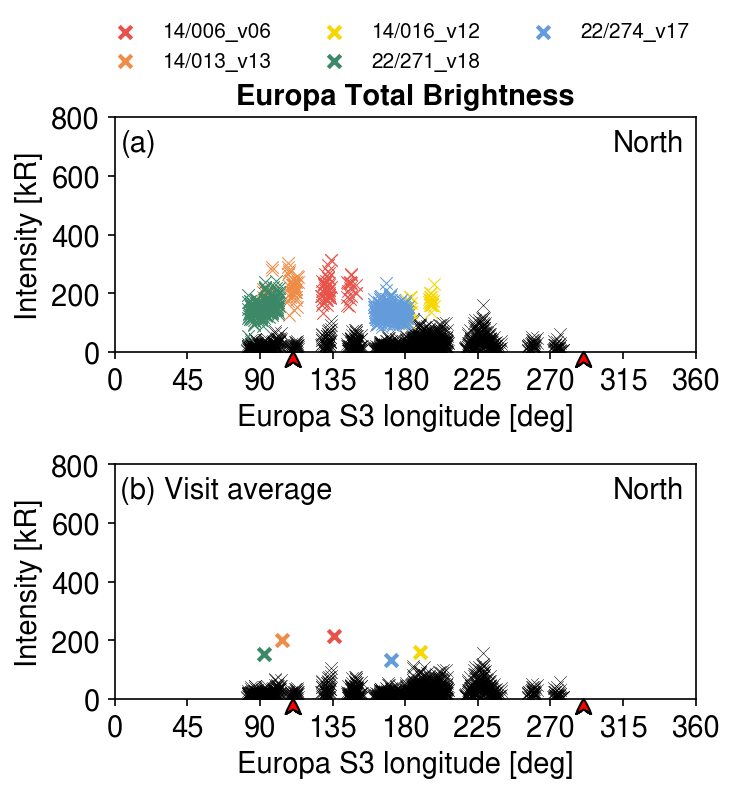

In [133]:
# ----- 1枚目のパネル -----
fontsize = 14
fig, ax = plt.subplots(2,1, figsize=(5,5.5), dpi=150)
ax[0].set_title('Europa Total Brightness', weight='bold', fontsize=fontsize)
ax[0].set_xlim(0,360)
ax[0].set_ylim(0,800)
# ax.set_yticks(np.linspace(-10,200,5))
# ax.set_yticklabels(np.linspace(-10,200,5))
ax[0].set_xticks(np.linspace(0,360,9))
ax[0].set_xticklabels(np.linspace(0,360,9, dtype=int))
ax[0].set_xlabel('Europa S3 longitude [deg]', fontsize=fontsize)
ax[0].set_ylabel('Intensity [kR]', fontsize=fontsize)
ax[0].tick_params(axis='x', labelsize=fontsize)
ax[0].tick_params(axis='y', labelsize=fontsize)
ax[0].text(0.01, 0.95, '(a)', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize)
ax[0].text(0.98, 0.95, hem, color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize)
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(moons30_arr, b0_arr+b1_arr, marker='x', c=cpalette[i], linewidths=0.5, label=doy[i], zorder=1)
for i in range(len(bkgdoy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+bkgdoy[i]+'/brightness.csv'         # Brightness at the model spot
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(moons30_arr, b0_arr, marker='x', c='#000000', linewidths=0.25, zorder=0.8)
# ax[0].axvline(x=110.61452513966482, color='#cfcfcf', zorder=0.5)
# ax[0].axvline(x=110.61452513966482+180, color='#cfcfcf', zorder=0.5)

# ----- 2枚目のパネル -----
# ax[1].set_title('Total Brightness (Average) ('+hem+')', weight='bold', fontsize=fontsize)
ax[1].set_xlim(0,360)
ax[1].set_ylim(0,800)
# ax.set_yticks(np.linspace(-10,200,5))
# ax.set_yticklabels(np.linspace(-10,200,5))
ax[1].set_xticks(np.linspace(0,360,9))
ax[1].set_xticklabels(np.linspace(0,360,9, dtype=int))
ax[1].set_xlabel('Europa S3 longitude [deg]', fontsize=fontsize)
ax[1].set_ylabel('Intensity [kR]', fontsize=fontsize)
ax[1].tick_params(axis='x', labelsize=fontsize)
ax[1].tick_params(axis='y', labelsize=fontsize)
ax[1].text(0.01, 0.95, '(b) Visit average', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize)
ax[1].text(0.98, 0.95, hem, color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize)
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_ave = np.average(efplat0_arr[idx])
    efpwlong0_ave = np.average(efpwlong0_arr[idx])
    moons30_ave = np.average(moons30_arr[idx])
    b0_ave = np.average(b0_arr[idx])
    b1_ave = np.average(b1_arr[idx])
    ax[1].scatter(moons30_ave, b0_ave+b1_ave, marker='x', c=cpalette[i], linewidths=2, label=doy[i], zorder=1)
for i in range(len(bkgdoy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+bkgdoy[i]+'/brightness.csv'         # Brightness at the model spot
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[1].scatter(moons30_arr, b0_arr, marker='x', c='#000000', linewidths=0.25, zorder=0.8)
# ax[1].axvline(x=110.61452513966482, color='#cfcfcf', zorder=0.5)
# ax[1].axvline(x=110.61452513966482+180, color='#cfcfcf', zorder=0.5)

for j in range(1):
    # obtain the handles and labels from the figure
    handles, labels = ax[j].get_legend_handles_labels()
    # copy the handles
    handles = [copy.copy(ha) for ha in handles ]
    # set the linewidths to the copies
    [ha.set_linewidth(2) for ha in handles ]
    ax[j].legend(handles=handles,
                 labels=labels,
                 loc='center left',
                 bbox_to_anchor=(-0.05, 1.3),
                 ncol=3,
                 frameon=False)

for i in range(2):
    ax[0].annotate('',
                xy=(110.61452513966482+180*i, 0), xycoords='data',
                xytext=(110.61452513966482+180*i, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))
    ax[1].annotate('',
                xy=(110.61452513966482+180*i, 0), xycoords='data',
                xytext=(110.61452513966482+180*i, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))

fig.tight_layout()
plt.show()

ローカルのバックグラウンド

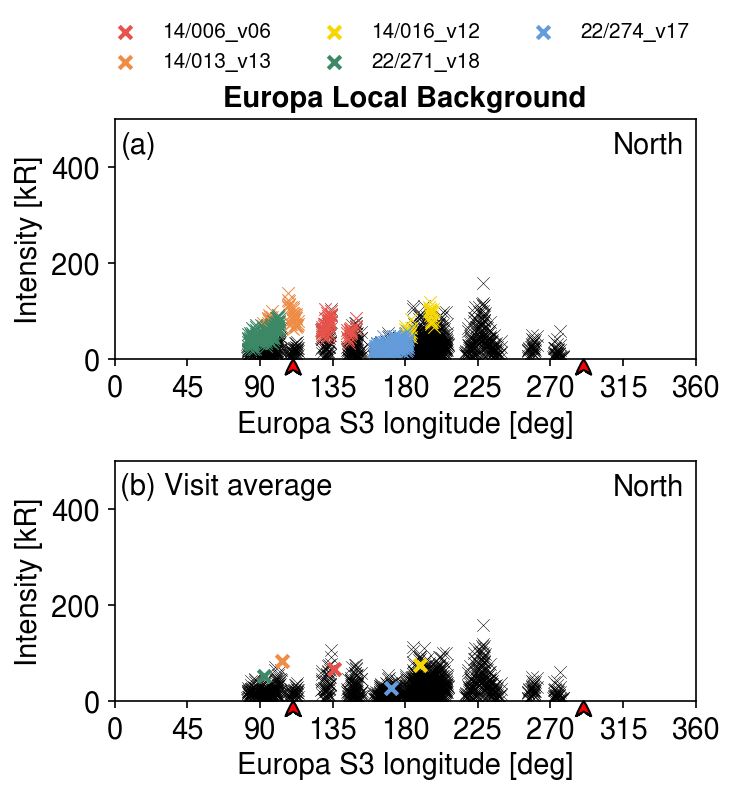

In [134]:
# ----- 1枚目のパネル -----
fontsize = 14
fig, ax = plt.subplots(2,1, figsize=(5,5.5), dpi=150)
ax[0].set_title('Europa Local Background', weight='bold', fontsize=fontsize)
ax[0].set_xlim(0,360)
ax[0].set_ylim(0,500)
# ax.set_yticks(np.linspace(-10,200,5))
# ax.set_yticklabels(np.linspace(-10,200,5))
ax[0].set_xticks(np.linspace(0,360,9))
ax[0].set_xticklabels(np.linspace(0,360,9, dtype=int))
ax[0].set_xlabel('Europa S3 longitude [deg]', fontsize=fontsize)
ax[0].set_ylabel('Intensity [kR]', fontsize=fontsize)
ax[0].tick_params(axis='x', labelsize=fontsize)
ax[0].tick_params(axis='y', labelsize=fontsize)
ax[0].text(0.01, 0.95, '(a)', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize)
ax[0].text(0.98, 0.95, hem, color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize)
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(moons30_arr, b1_arr, marker='x', c=cpalette[i], linewidths=0.5, label=doy[i], zorder=1)
for i in range(len(bkgdoy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+bkgdoy[i]+'/brightness.csv'         # Brightness at the model spot
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(moons30_arr, b0_arr, marker='x', c='#000000', linewidths=0.25, zorder=0.8)
# ax[0].axvline(x=110.61452513966482, color='#cfcfcf', zorder=0.5)
# ax[0].axvline(x=110.61452513966482+180, color='#cfcfcf', zorder=0.5)

# ----- 2枚目のパネル -----
# ax[1].set_title('Local Background (Average) ('+hem+')', weight='bold', fontsize=fontsize)
ax[1].set_xlim(0,360)
ax[1].set_ylim(0,500)
# ax.set_yticks(np.linspace(-10,200,5))
# ax.set_yticklabels(np.linspace(-10,200,5))
ax[1].set_xticks(np.linspace(0,360,9))
ax[1].set_xticklabels(np.linspace(0,360,9, dtype=int))
ax[1].set_xlabel('Europa S3 longitude [deg]', fontsize=fontsize)
ax[1].set_ylabel('Intensity [kR]', fontsize=fontsize)
ax[1].tick_params(axis='x', labelsize=fontsize)
ax[1].tick_params(axis='y', labelsize=fontsize)
ax[1].text(0.01, 0.95, '(b) Visit average', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize)
ax[1].text(0.98, 0.95, hem, color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize)
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_ave = np.average(efplat0_arr[idx])
    efpwlong0_ave = np.average(efpwlong0_arr[idx])
    moons30_ave = np.average(moons30_arr[idx])
    b0_ave = np.average(b0_arr[idx])
    b1_ave = np.average(b1_arr[idx])
    ax[1].scatter(moons30_ave, b1_ave, marker='x', c=cpalette[i], linewidths=2, label=doy[i], zorder=1)
for i in range(len(bkgdoy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+bkgdoy[i]+'/brightness.csv'         # Brightness at the model spot
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[1].scatter(moons30_arr, b0_arr, marker='x', c='#000000', linewidths=0.25, zorder=0.8)
# ax[1].axvline(x=110.61452513966482, color='#cfcfcf', zorder=0.5)
# ax[1].axvline(x=110.61452513966482+180, color='#cfcfcf', zorder=0.5)

for j in range(1):
    # obtain the handles and labels from the figure
    handles, labels = ax[j].get_legend_handles_labels()
    # copy the handles
    handles = [copy.copy(ha) for ha in handles ]
    # set the linewidths to the copies
    [ha.set_linewidth(2) for ha in handles ]
    ax[j].legend(handles=handles,
                 labels=labels,
                 loc='center left',
                 bbox_to_anchor=(-0.05, 1.3),
                 ncol=3,
                 frameon=False)

for i in range(2):
    ax[0].annotate('',
                xy=(110.61452513966482+180*i, 0), xycoords='data',
                xytext=(110.61452513966482+180*i, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))
    ax[1].annotate('',
                xy=(110.61452513966482+180*i, 0), xycoords='data',
                xytext=(110.61452513966482+180*i, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))

fig.tight_layout()
plt.show()

経度差

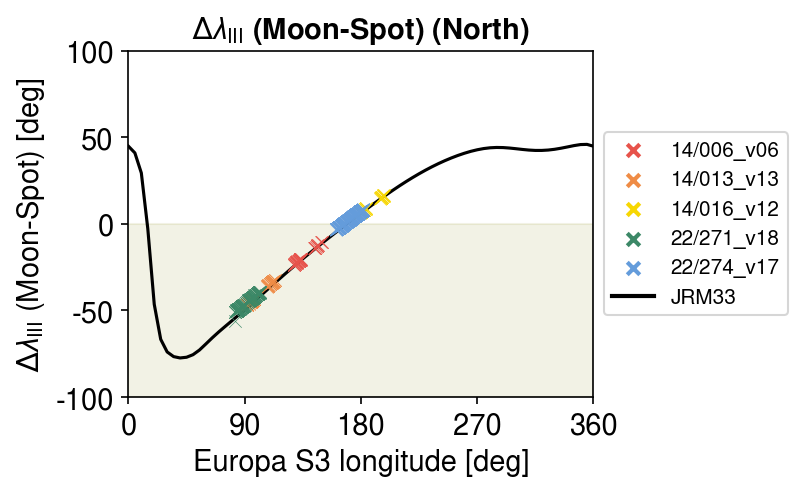

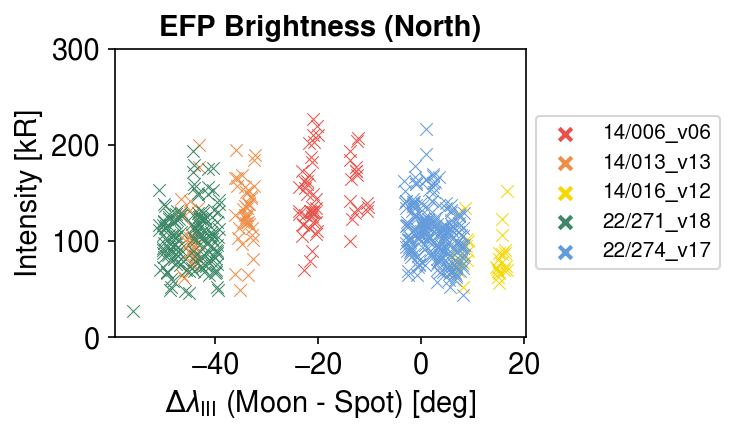

In [135]:
hem = 'North'

# JRM33
satovalN = np.recfromtxt('data/JRM33/satellite_foot_N.txt', skip_header=3,
                names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])

satovalS = np.recfromtxt('data/JRM33/satellite_foot_S.txt', skip_header=3,
                names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])

# 北半球
if hem == 'North':
    doy = north_doy
    satoval = satovalN
    wlon0 = copy.copy(satovalN.wlon[0:4])
    wlon1 = copy.copy(satovalN.wlon[2:])
    euwlon0 = copy.copy(satovalN.euwlon[0:4])
    euwlon1 = copy.copy(satovalN.euwlon[2:])
    euwlon0[3] += 360
    euwlon1[0] += -360
    
    wlon0 = copy.copy(satovalN.wlon)
    euwlon0 = copy.copy(satovalN.euwlon)
    euwlon0[0:3] += -360

# 南半球
elif hem == 'South':
    doy = south_doy
    satoval = satovalS
    wlon0 = copy.copy(satovalS.wlon[0:-1])
    wlon1 = copy.copy(satovalS.wlon[-3:])
    euwlon0 = copy.copy(satovalS.euwlon[0:-1])
    euwlon1 = copy.copy(satovalS.euwlon[-3:])
    euwlon0[-1] += 360
    euwlon1[0] += -360

# 1枚目 EFP Longitude
fontsize = 14
fig, ax = plt.subplots(1,1,figsize=(4,3),dpi=150)
# ax.set_aspect('equal')
ax.set_title('$\\Delta\\lambda_{\\mathrm{III}}$ (Moon-Spot) ('+hem+')', weight='bold', fontsize=fontsize)
ax.set_xlim(0,360)
ax.set_ylim(-100,100)
ax.set_xticks(np.linspace(0,360,5))
ax.set_xticklabels(np.linspace(0,360,5,dtype=int))
ax.set_yticks(np.linspace(-100,100,5))
ax.set_yticklabels(np.linspace(-100,100,5,dtype=int))
ax.set_xlabel('Europa S3 longitude [deg]', fontsize=fontsize)
ax.set_ylabel('$\\Delta\\lambda_{\\mathrm{III}}$ (Moon-Spot) [deg]', fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax.scatter(moons30_arr, -(efpwlong0_arr-moons30_arr), marker='x', c=cpalette[i], linewidths=0.3, label=doy[i], zorder=1)
    # ax.plot(moons30_arr, moons30_arr-efpwlong0_arr, color=cpalette[i])
ax.axhspan(-100, 0, color='olive', alpha=0.10, zorder=0.1)
ax.plot(wlon0, -(euwlon0-wlon0), color='k', label='JRM33', zorder=0.5)
# obtain the handles and labels from the figure
handles, labels = ax.get_legend_handles_labels()
# copy the handles
handles = [copy.copy(ha) for ha in handles ]
# set the linewidths to the copies
[ha.set_linewidth(2) for ha in handles ]
ax.legend(handles=handles, labels=labels, loc='center left', bbox_to_anchor=(1., .5))
plt.show()

# 2枚目 System III Difference vs Brightness
fontsize = 14
fig, ax = plt.subplots(1,1, figsize=(5,3), dpi=150)
ax.set_title('EFP Brightness ('+hem+')', weight='bold', fontsize=fontsize)
# ax.set_xlim(-60,20)
ax.set_ylim(0,300)
# ax.set_yticks(np.linspace(-10,200,5))
# ax.set_yticklabels(np.linspace(-10,200,5))
# ax.set_xticks(np.linspace(0,360,9))
# ax.set_xticklabels(np.linspace(0,360,9, dtype=int))
ax.set_xlabel('$\\Delta\\lambda_{\\mathrm{III}}$ (Moon - Spot) [deg]', fontsize=fontsize)
ax.set_ylabel('Intensity [kR]', fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax.scatter(moons30_arr-efpwlong0_arr, b0_arr, marker='x', c=cpalette[i], linewidths=0.5, label=doy[i], zorder=1)
# obtain the handles and labels from the figure
handles, labels = ax.get_legend_handles_labels()
# copy the handles
handles = [copy.copy(ha) for ha in handles ]
# set the linewidths to the copies
[ha.set_linewidth(2) for ha in handles ]
ax.legend(handles=handles, labels=labels, loc='center left', bbox_to_anchor=(1., .5))
fig.tight_layout()
plt.show()

### 横軸: フットプリントオーロラのS3経度

In [136]:
hem = 'South'
if hem == 'North':
    doy = north_doy
    bkgdoy = nbkg_doy
    bon17 = '0006'
elif hem == 'South':
    doy = south_doy
    bkgdoy = sbkg_doy
    bon17 = '0007'
else:
    doy = north_doy+south_doy
    bkgdoy = nbkg_doy+sbkg_doy

refnum = 0
if hem == 'South':
    refnum = 1
satoval = np.recfromtxt('ref/2021je007055-sup-000'+str(3+refnum)+'-table si-s0'+str(2+refnum)+'.txt', skip_header=3,
                names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])

xing_s3wlon_110 = ftpS3.ftpS3().FPW(110.61452513966482, satoval, 'EUROPA')
xing_s3wlon_290 = ftpS3.ftpS3().FPW(110.61452513966482+180, satoval, 'EUROPA')

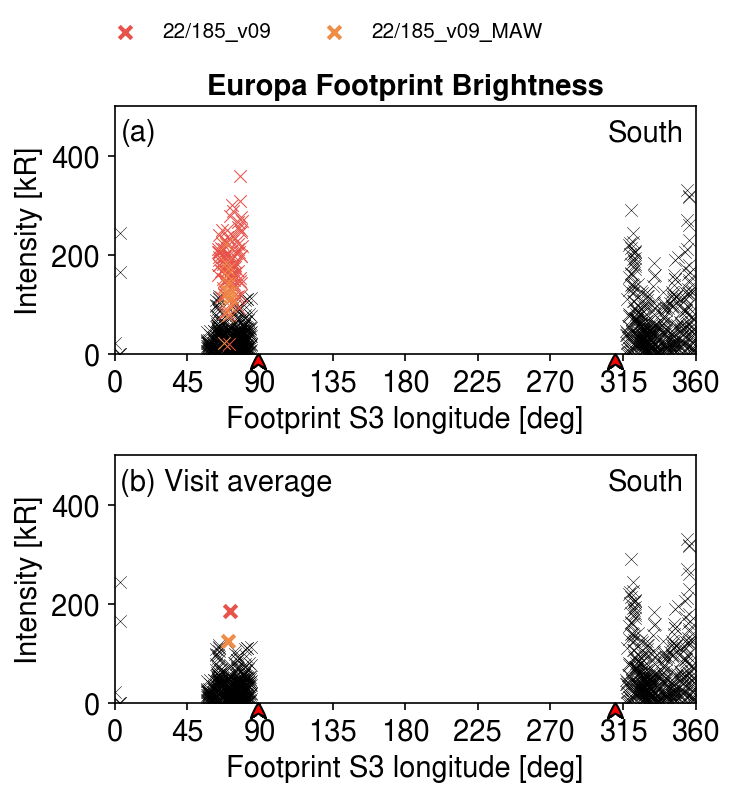

In [137]:
# ----- 1枚目のパネル -----
fontsize = 14
fig, ax = plt.subplots(2,1, figsize=(5,5.5), dpi=150)
ax[0].set_title('Europa Footprint Brightness', weight='bold', fontsize=fontsize)
ax[0].set_xlim(0,360)
ax[0].set_ylim(0,500)
# ax.set_yticks(np.linspace(-10,200,5))
# ax.set_yticklabels(np.linspace(-10,200,5))
ax[0].set_xticks(np.linspace(0,360,9))
ax[0].set_xticklabels(np.linspace(0,360,9, dtype=int))
ax[0].set_xlabel('Footprint S3 longitude [deg]', fontsize=fontsize)
ax[0].set_ylabel('Intensity [kR]', fontsize=fontsize)
ax[0].tick_params(axis='x', labelsize=fontsize)
ax[0].tick_params(axis='y', labelsize=fontsize)
ax[0].text(0.01, 0.95, '(a)', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize)
ax[0].text(0.98, 0.95, hem, color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize)
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'   # Footprint aurora brightness
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(efpwlong0_arr<0)     # なぜかマイナスの経度が含まれているので補正
    efpwlong0_arr[idx] += 360           # なぜかマイナスの経度が含まれているので補正
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(efpwlong0_arr, b0_arr, marker='x', c=cpalette[i], linewidths=0.5, label=doy[i], zorder=1)
for i in range(len(bkgdoy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+bkgdoy[i]+'/brightness.csv'         # Brightness at the model spot
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(efpwlong0_arr<0)     # なぜかマイナスの経度が含まれているので補正
    efpwlong0_arr[idx] += 360           # なぜかマイナスの経度が含まれているので補正
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(efpwlong0_arr, b0_arr, marker='x', c='#000000', linewidths=0.25, zorder=0.8)
# ax[0].axvline(x=110.61452513966482, color='#cfcfcf', zorder=0.5)
# ax[0].axvline(x=110.61452513966482+180, color='#cfcfcf', zorder=0.5)


# ----- 2枚目のパネル -----
# ax[1].set_title('Europa Footprint Brightness ('+hem+')', weight='bold', fontsize=fontsize)
ax[1].set_xlim(0,360)
ax[1].set_ylim(0,500)
# ax.set_yticks(np.linspace(-10,200,5))
# ax.set_yticklabels(np.linspace(-10,200,5))
ax[1].set_xticks(np.linspace(0,360,9))
ax[1].set_xticklabels(np.linspace(0,360,9, dtype=int))
ax[1].set_xlabel('Footprint S3 longitude [deg]', fontsize=fontsize)
ax[1].set_ylabel('Intensity [kR]', fontsize=fontsize)
ax[1].tick_params(axis='x', labelsize=fontsize)
ax[1].tick_params(axis='y', labelsize=fontsize)
ax[1].text(0.01, 0.95, '(b) Visit average', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize)
ax[1].text(0.98, 0.95, hem, color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize)
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(efpwlong0_arr<0)     # なぜかマイナスの経度が含まれているので補正
    efpwlong0_arr[idx] += 360           # なぜかマイナスの経度が含まれているので補正
    idx = np.where(b0_arr>0)
    efplat0_ave = np.average(efplat0_arr[idx])
    efpwlong0_ave = np.average(efpwlong0_arr[idx])
    moons30_ave = np.average(moons30_arr[idx])
    b0_ave = np.average(b0_arr[idx])
    b1_ave = np.average(b1_arr[idx])
    ax[1].scatter(efpwlong0_ave, b0_ave, marker='x', c=cpalette[i], linewidths=2, label=doy[i], zorder=1)
for i in range(len(bkgdoy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+bkgdoy[i]+'/brightness.csv'         # Brightness at the model spot
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(efpwlong0_arr<0)     # なぜかマイナスの経度が含まれているので補正
    efpwlong0_arr[idx] += 360           # なぜかマイナスの経度が含まれているので補正
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[1].scatter(efpwlong0_arr, b0_arr, marker='x', c='#000000', linewidths=0.25, zorder=0.8)
# ax[1].axvline(x=110.61452513966482, color='#cfcfcf', zorder=0.5)
# ax[1].axvline(x=110.61452513966482+180, color='#cfcfcf', zorder=0.5)


for j in range(1):
    # obtain the handles and labels from the figure
    handles, labels = ax[j].get_legend_handles_labels()
    # copy the handles
    handles = [copy.copy(ha) for ha in handles ]
    # set the linewidths to the copies
    [ha.set_linewidth(2) for ha in handles ]
    ax[j].legend(handles=handles,
                 labels=labels,
                 loc='center left',
                 bbox_to_anchor=(-0.05, 1.3),
                 ncol=3,
                 frameon=False)

for i in range(2):
    ax[i].annotate('',
                xy=(xing_s3wlon_110, 0), xycoords='data',
                xytext=(xing_s3wlon_110, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))
    ax[i].annotate('',
                xy=(xing_s3wlon_290, 0), xycoords='data',
                xytext=(xing_s3wlon_290, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))


fig.tight_layout()
plt.show()

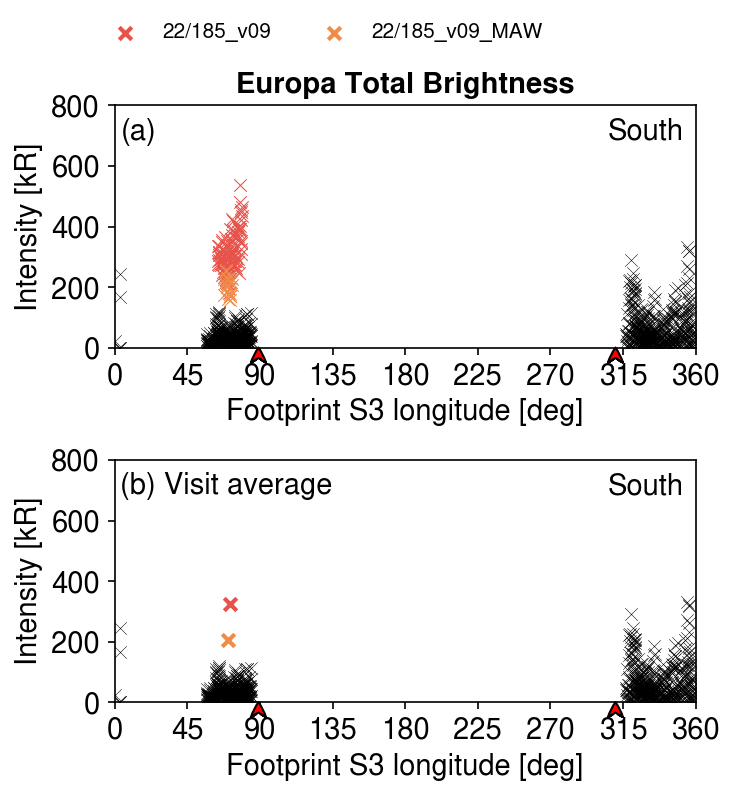

In [138]:
# ----- 1枚目のパネル -----
fontsize = 14
fig, ax = plt.subplots(2,1, figsize=(5,5.5), dpi=150)
ax[0].set_title('Europa Total Brightness', weight='bold', fontsize=fontsize)
ax[0].set_xlim(0,360)
ax[0].set_ylim(0,800)
# ax.set_yticks(np.linspace(-10,200,5))
# ax.set_yticklabels(np.linspace(-10,200,5))
ax[0].set_xticks(np.linspace(0,360,9))
ax[0].set_xticklabels(np.linspace(0,360,9, dtype=int))
ax[0].set_xlabel('Footprint S3 longitude [deg]', fontsize=fontsize)
ax[0].set_ylabel('Intensity [kR]', fontsize=fontsize)
ax[0].tick_params(axis='x', labelsize=fontsize)
ax[0].tick_params(axis='y', labelsize=fontsize)
ax[0].text(0.01, 0.95, '(a)', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize)
ax[0].text(0.98, 0.95, hem, color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize)
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'   # Footprint aurora brightness
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(efpwlong0_arr<0)     # なぜかマイナスの経度が含まれているので補正
    efpwlong0_arr[idx] += 360           # なぜかマイナスの経度が含まれているので補正
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(efpwlong0_arr, b0_arr+b1_arr, marker='x', c=cpalette[i], linewidths=0.5, label=doy[i], zorder=1)
for i in range(len(bkgdoy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+bkgdoy[i]+'/brightness.csv'         # Brightness at the model spot
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(efpwlong0_arr<0)     # なぜかマイナスの経度が含まれているので補正
    efpwlong0_arr[idx] += 360           # なぜかマイナスの経度が含まれているので補正
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(efpwlong0_arr, b0_arr, marker='x', c='#000000', linewidths=0.25, zorder=0.8)
# ax[0].axvline(x=110.61452513966482, color='#cfcfcf', zorder=0.5)
# ax[0].axvline(x=110.61452513966482+180, color='#cfcfcf', zorder=0.5)


# ----- 2枚目のパネル -----
# ax[1].set_title('Europa Footprint Brightness ('+hem+')', weight='bold', fontsize=fontsize)
ax[1].set_xlim(0,360)
ax[1].set_ylim(0,800)
# ax.set_yticks(np.linspace(-10,200,5))
# ax.set_yticklabels(np.linspace(-10,200,5))
ax[1].set_xticks(np.linspace(0,360,9))
ax[1].set_xticklabels(np.linspace(0,360,9, dtype=int))
ax[1].set_xlabel('Footprint S3 longitude [deg]', fontsize=fontsize)
ax[1].set_ylabel('Intensity [kR]', fontsize=fontsize)
ax[1].tick_params(axis='x', labelsize=fontsize)
ax[1].tick_params(axis='y', labelsize=fontsize)
ax[1].text(0.01, 0.95, '(b) Visit average', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize)
ax[1].text(0.98, 0.95, hem, color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize)
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(efpwlong0_arr<0)     # なぜかマイナスの経度が含まれているので補正
    efpwlong0_arr[idx] += 360           # なぜかマイナスの経度が含まれているので補正
    idx = np.where(b0_arr>0)
    efplat0_ave = np.average(efplat0_arr[idx])
    efpwlong0_ave = np.average(efpwlong0_arr[idx])
    moons30_ave = np.average(moons30_arr[idx])
    b0_ave = np.average(b0_arr[idx])
    b1_ave = np.average(b1_arr[idx])
    ax[1].scatter(efpwlong0_ave, b0_ave+b1_ave, marker='x', c=cpalette[i], linewidths=2, label=doy[i], zorder=1)
for i in range(len(bkgdoy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+bkgdoy[i]+'/brightness.csv'         # Brightness at the model spot
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(efpwlong0_arr<0)     # なぜかマイナスの経度が含まれているので補正
    efpwlong0_arr[idx] += 360           # なぜかマイナスの経度が含まれているので補正
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[1].scatter(efpwlong0_arr, b0_arr, marker='x', c='#000000', linewidths=0.25, zorder=0.8)
# ax[1].axvline(x=110.61452513966482, color='#cfcfcf', zorder=0.5)
# ax[1].axvline(x=110.61452513966482+180, color='#cfcfcf', zorder=0.5)


for j in range(1):
    # obtain the handles and labels from the figure
    handles, labels = ax[j].get_legend_handles_labels()
    # copy the handles
    handles = [copy.copy(ha) for ha in handles ]
    # set the linewidths to the copies
    [ha.set_linewidth(2) for ha in handles ]
    ax[j].legend(handles=handles,
                 labels=labels,
                 loc='center left',
                 bbox_to_anchor=(-0.05, 1.3),
                 ncol=3,
                 frameon=False)

for i in range(2):
    ax[i].annotate('',
                xy=(xing_s3wlon_110, 0), xycoords='data',
                xytext=(xing_s3wlon_110, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))
    ax[i].annotate('',
                xy=(xing_s3wlon_290, 0), xycoords='data',
                xytext=(xing_s3wlon_290, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))


fig.tight_layout()
plt.show()

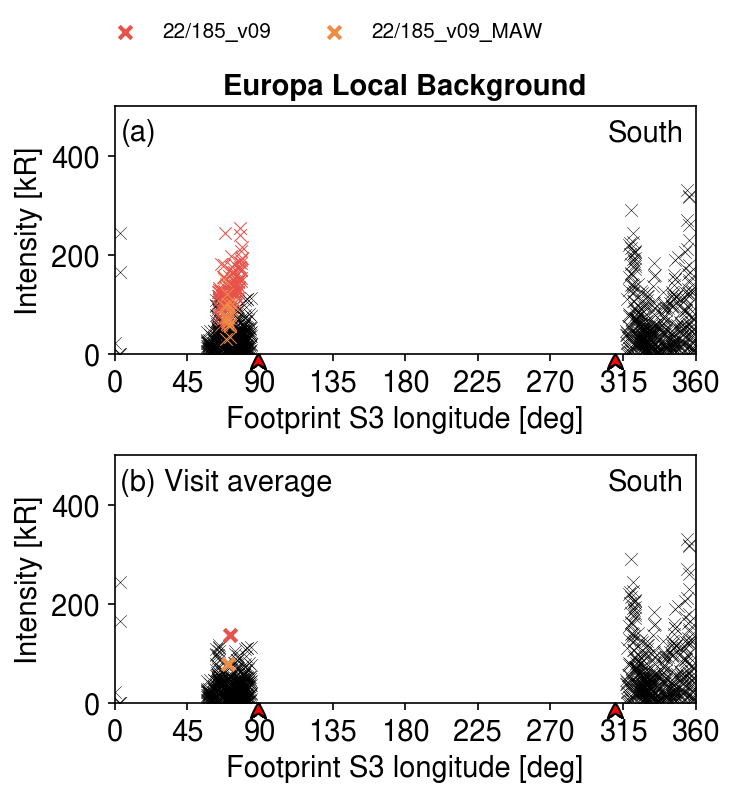

In [139]:
# ----- 1枚目のパネル -----
fontsize = 14
fig, ax = plt.subplots(2,1, figsize=(5,5.5), dpi=150)
ax[0].set_title('Europa Local Background', weight='bold', fontsize=fontsize)
ax[0].set_xlim(0,360)
ax[0].set_ylim(0,500)
# ax.set_yticks(np.linspace(-10,200,5))
# ax.set_yticklabels(np.linspace(-10,200,5))
ax[0].set_xticks(np.linspace(0,360,9))
ax[0].set_xticklabels(np.linspace(0,360,9, dtype=int))
ax[0].set_xlabel('Footprint S3 longitude [deg]', fontsize=fontsize)
ax[0].set_ylabel('Intensity [kR]', fontsize=fontsize)
ax[0].tick_params(axis='x', labelsize=fontsize)
ax[0].tick_params(axis='y', labelsize=fontsize)
ax[0].text(0.01, 0.95, '(a)', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize)
ax[0].text(0.98, 0.95, hem, color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize)
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'   # Footprint aurora brightness
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(efpwlong0_arr<0)     # なぜかマイナスの経度が含まれているので補正
    efpwlong0_arr[idx] += 360           # なぜかマイナスの経度が含まれているので補正
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(efpwlong0_arr, b1_arr, marker='x', c=cpalette[i], linewidths=0.5, label=doy[i], zorder=1)
for i in range(len(bkgdoy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+bkgdoy[i]+'/brightness.csv'         # Brightness at the model spot
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(efpwlong0_arr<0)     # なぜかマイナスの経度が含まれているので補正
    efpwlong0_arr[idx] += 360           # なぜかマイナスの経度が含まれているので補正
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(efpwlong0_arr, b0_arr, marker='x', c='#000000', linewidths=0.25, zorder=0.8)
# ax[0].axvline(x=110.61452513966482, color='#cfcfcf', zorder=0.5)
# ax[0].axvline(x=110.61452513966482+180, color='#cfcfcf', zorder=0.5)


# ----- 2枚目のパネル -----
# ax[1].set_title('Europa Footprint Brightness ('+hem+')', weight='bold', fontsize=fontsize)
ax[1].set_xlim(0,360)
ax[1].set_ylim(0,500)
# ax.set_yticks(np.linspace(-10,200,5))
# ax.set_yticklabels(np.linspace(-10,200,5))
ax[1].set_xticks(np.linspace(0,360,9))
ax[1].set_xticklabels(np.linspace(0,360,9, dtype=int))
ax[1].set_xlabel('Footprint S3 longitude [deg]', fontsize=fontsize)
ax[1].set_ylabel('Intensity [kR]', fontsize=fontsize)
ax[1].tick_params(axis='x', labelsize=fontsize)
ax[1].tick_params(axis='y', labelsize=fontsize)
ax[1].text(0.01, 0.95, '(b) Visit average', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize)
ax[1].text(0.98, 0.95, hem, color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize)
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(efpwlong0_arr<0)     # なぜかマイナスの経度が含まれているので補正
    efpwlong0_arr[idx] += 360           # なぜかマイナスの経度が含まれているので補正
    idx = np.where(b0_arr>0)
    efplat0_ave = np.average(efplat0_arr[idx])
    efpwlong0_ave = np.average(efpwlong0_arr[idx])
    moons30_ave = np.average(moons30_arr[idx])
    b0_ave = np.average(b0_arr[idx])
    b1_ave = np.average(b1_arr[idx])
    ax[1].scatter(efpwlong0_ave, b1_ave, marker='x', c=cpalette[i], linewidths=2, label=doy[i], zorder=1)
for i in range(len(bkgdoy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+bkgdoy[i]+'/brightness.csv'         # Brightness at the model spot
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(efpwlong0_arr<0)     # なぜかマイナスの経度が含まれているので補正
    efpwlong0_arr[idx] += 360           # なぜかマイナスの経度が含まれているので補正
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[1].scatter(efpwlong0_arr, b0_arr, marker='x', c='#000000', linewidths=0.25, zorder=0.8)
# ax[1].axvline(x=110.61452513966482, color='#cfcfcf', zorder=0.5)
# ax[1].axvline(x=110.61452513966482+180, color='#cfcfcf', zorder=0.5)


for j in range(1):
    # obtain the handles and labels from the figure
    handles, labels = ax[j].get_legend_handles_labels()
    # copy the handles
    handles = [copy.copy(ha) for ha in handles ]
    # set the linewidths to the copies
    [ha.set_linewidth(2) for ha in handles ]
    ax[j].legend(handles=handles,
                 labels=labels,
                 loc='center left',
                 bbox_to_anchor=(-0.05, 1.3),
                 ncol=3,
                 frameon=False)

for i in range(2):
    ax[i].annotate('',
                xy=(xing_s3wlon_110, 0), xycoords='data',
                xytext=(xing_s3wlon_110, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))
    ax[i].annotate('',
                xy=(xing_s3wlon_290, 0), xycoords='data',
                xytext=(xing_s3wlon_290, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))


fig.tight_layout()
plt.show()

公転面における経度差

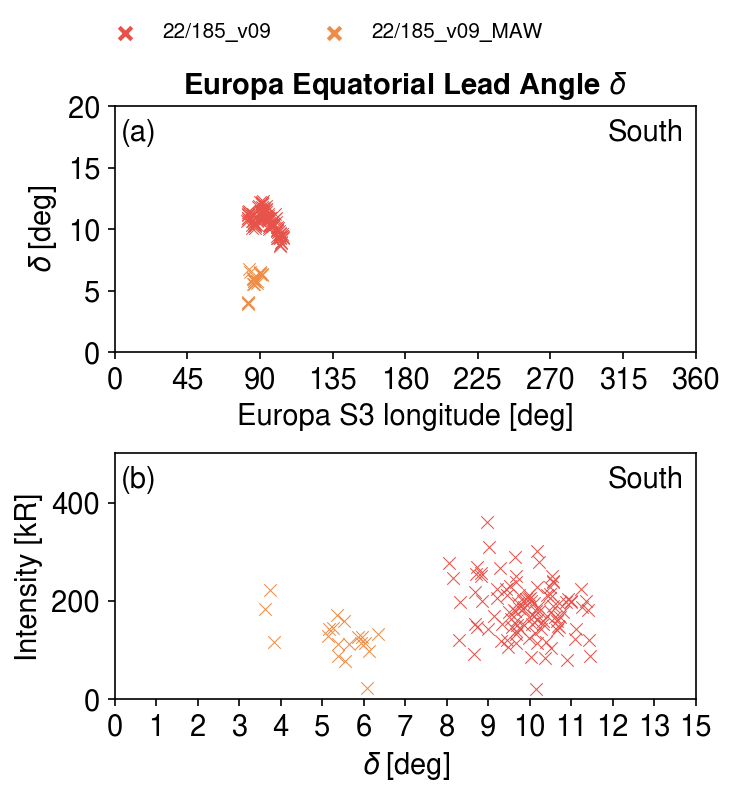

In [140]:
# ----- 1枚目のパネル -----
fontsize = 14
fig, ax = plt.subplots(2,1, figsize=(5,5.5), dpi=150)
ax[0].set_title('Europa Equatorial Lead Angle $\\delta$', weight='bold', fontsize=fontsize)
ax[0].set_xlim(0,360)
ax[0].set_ylim(0,20)
# ax.set_yticks(np.linspace(-10,200,5))
# ax.set_yticklabels(np.linspace(-10,200,5))
ax[0].set_xticks(np.linspace(0,360,9))
ax[0].set_xticklabels(np.linspace(0,360,9, dtype=int))
ax[0].set_xlabel('Europa S3 longitude [deg]', fontsize=fontsize)
ax[0].set_ylabel('$\\delta$ [deg]', fontsize=fontsize)
ax[0].tick_params(axis='x', labelsize=fontsize)
ax[0].tick_params(axis='y', labelsize=fontsize)
ax[0].text(0.01, 0.95, '(a)', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize)
ax[0].text(0.98, 0.95, hem, color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize)
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'   # Footprint aurora brightness
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    idx = np.where(efpwlong0_arr<0)     # なぜかマイナスの経度が含まれているので補正
    efpwlong0_arr[idx] += 360           # なぜかマイナスの経度が含まれているので補正
    eqwlon_arr = np.zeros(efpwlong0_arr.shape)  # instantaneous field line on the orbital equator
    for j in range(eqwlon_arr.size):
        eqwlon_arr[j] = ftpS3.ftpS3().S3EQ(efpwlong0_arr[j], satoval, 'EUROPA')
    eq_leadangle = moons30_arr-eqwlon_arr       # lead angle on the orbital equator
    idx = np.where(eq_leadangle>=0)
    ax[0].scatter(moons30_arr[idx], eq_leadangle[idx], marker='x', c=cpalette[i], linewidths=0.5, label=doy[i], zorder=1)
    np.savetxt('data/red3_leadangle/EUROPA/20'+doy[i]+'R_eq.txt', np.array([moons30_arr[idx], eq_leadangle[idx]]))
"""
# Bonfond+2017の観測データも重ねてみる (リード角がマイナスになるので何かがおかしい)
bon17_efp = np.loadtxt('data/Bonfond_etal_2017/jgra53671-sup-'+bon17+'-DataSetS3.txt',
           skiprows=1,
           usecols=(3,4,5,6,7,8,9))
lon_eur17 = bon17_efp[:,0]
lon_efp17 = bon17_efp[:,1]
lat_efp17 = bon17_efp[:,2]
lon_efp17_pl = bon17_efp[:,3]
lon_efp17_mn = bon17_efp[:,4]
lat_efp17_pl = bon17_efp[:,5]
lat_efp17_mn = bon17_efp[:,6]
eqwlon_efp17 = np.zeros(lon_efp17.shape)
for jj in range(lon_efp17.size):
    eqwlon_efp17[jj] = ftpS3.ftpS3().S3EQ(lon_efp17_mn[jj], satoval, 'EUROPA')
    if lon_eur17[jj]-eqwlon_efp17[jj] < 0:
        print(lon_eur17[jj], eqwlon_efp17[jj], lat_efp17[jj], lon_efp17[jj])
eq_leadangle = lon_eur17-eqwlon_efp17
ax[0].scatter(lon_eur17, eq_leadangle, marker='x', c='k', linewidths=0.5, label='Bonfond+17', zorder=1)
"""
"""
bon17_efp = np.loadtxt('data/Bon17_leadangle.txt')
dateidx = ['04/18/2005', '04/25/2005',
           '02/07/2006', '02/21/2007',
           '02/22/2007', '02/26/2007',
           '03/02/2007', '03/05/2007',
           '03/09/2007', '05/22/2007']
pdcsv = pd.read_csv('data/Bonfond_etal_2017/jgra53671-sup-0006-DataSetS3.txt', sep='\t')
dateUT = pdcsv.loc[:, 'date']
timeUT = pdcsv.loc[:, 'time']
S3eurUT = pdcsv.loc[:, 'lon_eu']
S3efpUT = pdcsv.loc[:, 'lon_efp']
moonS3 = bon17_efp[0,:]
efpeqS3 = bon17_efp[1,:]
dateidx = dateidx[1]
# moonS3 = moonS3[dateUT==dateidx]
# fpeqS3 = efpeqS3[dateUT==dateidx]
for i in range(moonS3.size):
    # print(dateidx, 'Moon', moonS3[i], 'FP', efpeqS3[i])
    _, EFP_inst, _, _, _ = ftpS3.ftpS3().FP(utc=dateUT[i]+'-'+timeUT[i], satmodel=satoval, MOON='EUROPA')
    print(dateidx, EFP_inst-S3efpUT[i], moonS3[i]-efpeqS3[i])
ax[0].scatter(moonS3, moonS3-efpeqS3, marker='x', c='k', linewidths=0.5, label=dateidx, zorder=1)
"""


# ----- 2枚目のパネル -----
# ax[1].set_title('Europa Footprint Brightness ('+hem+')', weight='bold', fontsize=fontsize)
ax[1].set_xlim(0,15)
ax[1].set_ylim(0,500)
# ax.set_yticks(np.linspace(-10,200,5))
# ax.set_yticklabels(np.linspace(-10,200,5))
ax[1].set_xticks(np.linspace(0,15,15))
ax[1].set_xticklabels(np.linspace(0,15,15, dtype=int))
ax[1].set_xlabel('$\\delta$ [deg]', fontsize=fontsize)
ax[1].set_ylabel('Intensity [kR]', fontsize=fontsize)
ax[1].tick_params(axis='x', labelsize=fontsize)
ax[1].tick_params(axis='y', labelsize=fontsize)
ax[1].text(0.01, 0.95, '(b)', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize)
ax[1].text(0.98, 0.95, hem, color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize)
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'   # Footprint aurora brightness
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    idx = np.where(efpwlong0_arr<0)     # なぜかマイナスの経度が含まれているので補正
    efpwlong0_arr[idx] += 360           # なぜかマイナスの経度が含まれているので補正
    # moonwlon_arr = np.zeros(efpwlong0_arr.shape)    # moon's w-longitude on the orbital equator
    eqwlon_arr = np.zeros(efpwlong0_arr.shape)      # instantaneous field line on the orbital equator
    for j in range(eqwlon_arr.size):
        # moonwlon_arr[j],_,_,_,_ = ftpS3.ftpS3().FP(utc[j], satoval, 'EUROPA')
        eqwlon_arr[j] = ftpS3.ftpS3().S3EQ(efpwlong0_arr[j], satoval, 'EUROPA')
    eq_leadangle = moons30_arr-eqwlon_arr       # lead angle on the orbital equator
    idx = np.where(eq_leadangle>=0)
    ax[1].scatter(eq_leadangle[idx], b0_arr[idx], marker='x', c=cpalette[i], linewidths=0.5, label=doy[i], zorder=1)


for j in range(1):
    # obtain the handles and labels from the figure
    handles, labels = ax[j].get_legend_handles_labels()
    # copy the handles
    handles = [copy.copy(ha) for ha in handles ]
    # set the linewidths to the copies
    [ha.set_linewidth(2) for ha in handles ]
    ax[j].legend(handles=handles,
                 labels=labels,
                 loc='center left',
                 bbox_to_anchor=(-0.05, 1.3),
                 ncol=3,
                 frameon=False)

fig.tight_layout()
plt.show()

### 北・南半球合計

North min 255.90276064949404
North Max 277.87225046845924
North min 147.81802342312173
North Max 169.8953620185564
North min 183.8296845610695
North Max 206.056153676053
North min 128.09716911462934
North Max 150.06938632019043
North min 91.40618667185552
North Max 113.5622258622391
North min 179.09332967207425
North Max 200.7705411608891
North min 184.38019526714655
North Max 206.5748036321162
North min 185.33650102568237
North Max 189.3354374416812
North min 82.01019595251879
North Max 103.0623137001098
North min 160.73205050953507
North Max 181.790729456854
North min 217.27505489285605
North Max 239.40359928332927
North min 183.12174009367232
North Max 201.94705646177076
South min 298.4847878367749
South Max 320.2685313820701
South min 82.14936417115464
South Max 104.0868307205521
South min 332.8320828066251
South Max 354.8773285106488
South min 333.1388724370375
South Max 334.8267178776086
South min 60.284412822776474
South Max 82.75449152182209
South min 309.23166967531466
South M

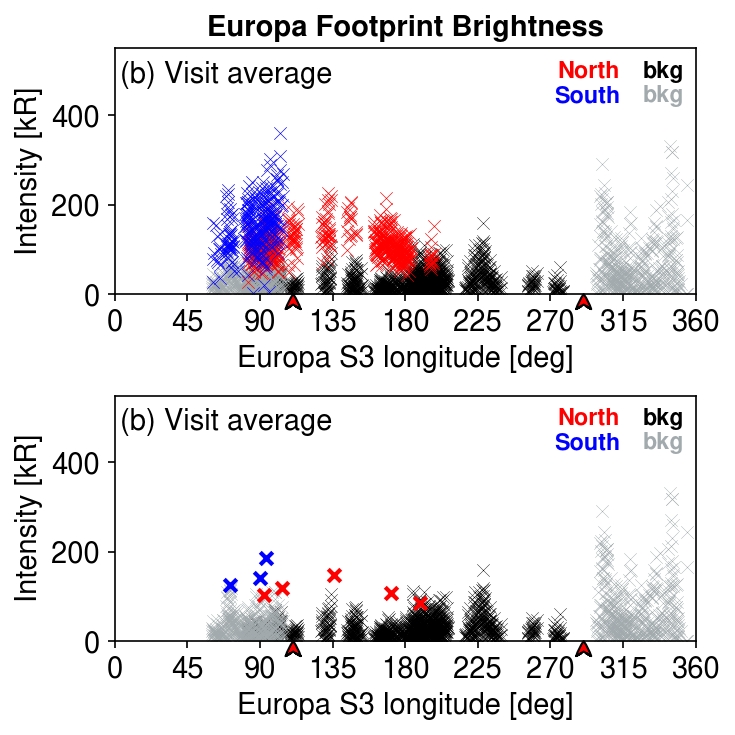

In [141]:
north_doy = ['14/006_v06', '14/013_v13', '14/016_v12', '22/271_v18', '22/274_v17']
south_doy = ['22/185_v09', '22/310_v19', '22/349_v23']

# ----- 1枚目のパネル -----
fontsize = 14
fig, ax = plt.subplots(2,1, figsize=(5,5), dpi=150)
ax[0].set_title('Europa Footprint Brightness', weight='bold', fontsize=fontsize)
ax[0].set_xlim(0,360)
ax[0].set_ylim(0,550)
# ax.set_yticks(np.linspace(-10,200,5))
# ax.set_yticklabels(np.linspace(-10,200,5))
ax[0].set_xticks(np.linspace(0,360,9))
ax[0].set_xticklabels(np.linspace(0,360,9, dtype=int))
ax[0].set_xlabel('Europa S3 longitude [deg]', fontsize=fontsize)
ax[0].set_ylabel('Intensity [kR]', fontsize=fontsize)
ax[0].tick_params(axis='x', labelsize=fontsize)
ax[0].tick_params(axis='y', labelsize=fontsize)
ax[0].text(0.01, 0.95, '(b) Visit average', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize)
ax[0].text(0.87, 0.95, 'North', fontweight='bold', color='r',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize*0.8)
ax[0].text(0.98, 0.95, 'bkg', fontweight='bold', color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize*0.8)
ax[0].text(0.87, 0.85, 'South', fontweight='bold', color='b',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize*0.8)
ax[0].text(0.98, 0.85, 'bkg', fontweight='bold', color='#A2AAAD',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize*0.8)
for i in range(len(north_doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+north_doy[i]+'/brightness.csv'   # Footprint aurora brightness
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(moons30_arr, b0_arr, marker='x', c='r', linewidths=0.3, zorder=1)
    # print('North min', np.min(moons30_arr))
    # print('North Max', np.max(moons30_arr))
for i in range(len(south_doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+south_doy[i]+'/brightness.csv'   # Footprint aurora brightness
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(moons30_arr, b0_arr, marker='x', c='b', linewidths=0.3, zorder=1)
    # print('South min', np.min(moons30_arr))
    # print('South Max', np.max(moons30_arr))
for i in range(len(nbkg_doy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+nbkg_doy[i]+'/brightness.csv'         # Brightness at the model spot
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(moons30_arr, b0_arr, marker='x', c='#000000', linewidths=0.2, zorder=0.8)
    print('North min', np.min(moons30_arr))
    print('North Max', np.max(moons30_arr))
for i in range(len(sbkg_doy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+sbkg_doy[i]+'/brightness.csv'         # Brightness at the model spot
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(moons30_arr, b0_arr, marker='x', c='#A2AAAD', linewidths=0.2, zorder=0.8)
    print('South min', np.min(moons30_arr))
    print('South Max', np.max(moons30_arr))
# ax[0].axvline(x=110.61452513966482, color='#cfcfcf', zorder=0.5)
# ax[0].axvline(x=110.61452513966482+180, color='#cfcfcf', zorder=0.5)


# ----- 2枚目のパネル -----
# ax[1].set_title('Europa Footprint Brightness ('+hem+')', weight='bold', fontsize=fontsize)
ax[1].set_xlim(0,360)
ax[1].set_ylim(0,550)
# ax.set_yticks(np.linspace(-10,200,5))
# ax.set_yticklabels(np.linspace(-10,200,5))
ax[1].set_xticks(np.linspace(0,360,9))
ax[1].set_xticklabels(np.linspace(0,360,9, dtype=int))
ax[1].set_xlabel('Europa S3 longitude [deg]', fontsize=fontsize)
ax[1].set_ylabel('Intensity [kR]', fontsize=fontsize)
ax[1].tick_params(axis='x', labelsize=fontsize)
ax[1].tick_params(axis='y', labelsize=fontsize)
ax[1].text(0.01, 0.95, '(b) Visit average', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize)
ax[1].text(0.87, 0.95, 'North', fontweight='bold', color='r',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize*0.8)
ax[1].text(0.98, 0.95, 'bkg', fontweight='bold', color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize*0.8)
ax[1].text(0.87, 0.85, 'South', fontweight='bold', color='b',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize*0.8)
ax[1].text(0.98, 0.85, 'bkg', fontweight='bold', color='#A2AAAD',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize*0.8)
for i in range(len(north_doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+north_doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_ave = np.average(efplat0_arr[idx])
    efpwlong0_ave = np.average(efpwlong0_arr[idx])
    moons30_ave = np.average(moons30_arr[idx])
    b0_ave = np.average(b0_arr[idx])
    b1_ave = np.average(b1_arr[idx])
    ax[1].scatter(moons30_ave, b0_ave, marker='x', c='r', linewidths=2, zorder=1)
for i in range(len(south_doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+south_doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_ave = np.average(efplat0_arr[idx])
    efpwlong0_ave = np.average(efpwlong0_arr[idx])
    moons30_ave = np.average(moons30_arr[idx])
    b0_ave = np.average(b0_arr[idx])
    b1_ave = np.average(b1_arr[idx])
    ax[1].scatter(moons30_ave, b0_ave, marker='x', c='b', linewidths=2, zorder=1)
for i in range(len(nbkg_doy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+nbkg_doy[i]+'/brightness.csv'         # Brightness at the model spot
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[1].scatter(moons30_arr, b0_arr, marker='x', c='#000000', linewidths=0.2, zorder=0.8)
for i in range(len(sbkg_doy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+sbkg_doy[i]+'/brightness.csv'         # Brightness at the model spot
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[1].scatter(moons30_arr, b0_arr, marker='x', c='#A2AAAD', linewidths=0.2, zorder=0.8)

for i in range(2):
    ax[0].annotate('',
                xy=(110.61452513966482+180*i, 0), xycoords='data',
                xytext=(110.61452513966482+180*i, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))
    ax[1].annotate('',
                xy=(110.61452513966482+180*i, 0), xycoords='data',
                xytext=(110.61452513966482+180*i, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))


fig.tight_layout()
plt.show()

### Local Time

In [142]:
hem = 'South'
if hem == 'North':
    doy = north_doy
    bkgdoy = nbkg_doy
elif hem == 'South':
    doy = south_doy
    bkgdoy = sbkg_doy
else:
    doy = north_doy+south_doy
    bkgdoy = nbkg_doy+sbkg_doy

refnum = 0
if hem == 'South':
    refnum = 1
satoval = np.recfromtxt('ref/2021je007055-sup-000'+str(3+refnum)+'-table si-s0'+str(2+refnum)+'.txt', skip_header=3,
                names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])

xing_s3wlon_110 = ftpS3.ftpS3().FPW(110.61452513966482, satoval, 'EUROPA')
xing_s3wlon_290 = ftpS3.ftpS3().FPW(110.61452513966482+180, satoval, 'EUROPA')

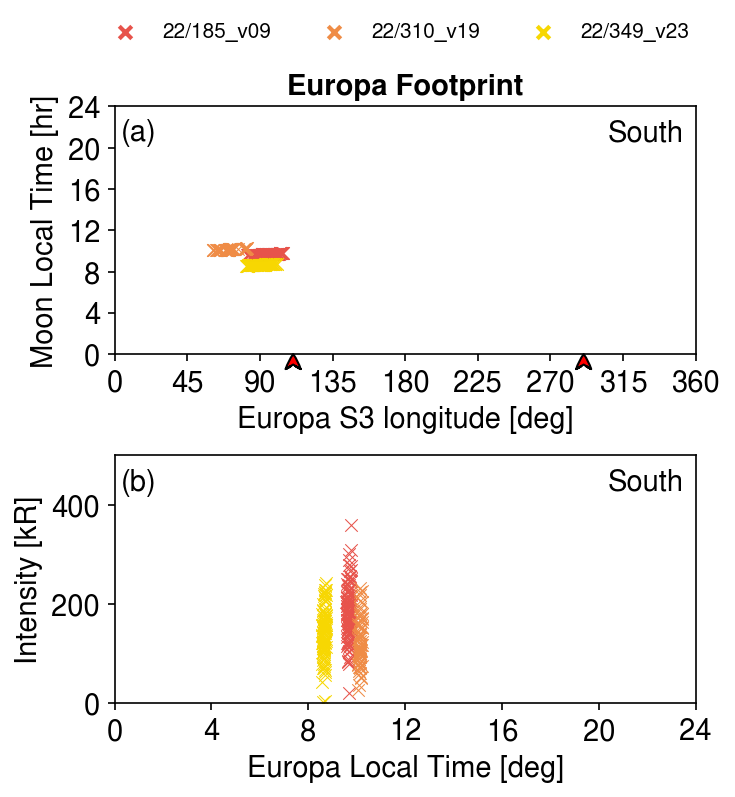

In [143]:
# ----- 1枚目のパネル -----
fontsize = 14
fig, ax = plt.subplots(2,1, figsize=(5,5.5), dpi=150)
ax[0].set_title('Europa Footprint', weight='bold', fontsize=fontsize)
ax[0].set_xlim(0,360)
ax[0].set_ylim(0,24*3600)
# ax.set_yticks(np.linspace(-10,200,5))
# ax.set_yticklabels(np.linspace(-10,200,5))
ax[0].set_xticks(np.linspace(0,360,9))
ax[0].set_xticklabels(np.linspace(0,360,9, dtype=int))
ax[0].set_yticks(np.linspace(0,24*3600,7))
ax[0].set_yticklabels(np.linspace(0,24,7, dtype=int))
ax[0].set_xlabel('Europa S3 longitude [deg]', fontsize=fontsize)
ax[0].set_ylabel('Moon Local Time [hr]', fontsize=fontsize)
ax[0].tick_params(axis='x', labelsize=fontsize)
ax[0].tick_params(axis='y', labelsize=fontsize)
ax[0].text(0.01, 0.95, '(a)', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize)
ax[0].text(0.98, 0.95, hem, color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize)
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'   # Footprint aurora brightness
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    LTime = np.zeros(b0_arr.size)
    for j in range(b0_arr.size):
        elong, LTime[j] = localtime.LT().lt(utc[j])
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    LTime = LTime[idx]
    ax[0].scatter(moons30_arr, LTime, marker='x', c=cpalette[i], linewidths=0.5, label=doy[i], zorder=1)


# ----- 2枚目のパネル -----
# ax[1].set_title('Europa Footprint Brightness ('+hem+')', weight='bold', fontsize=fontsize)
ax[1].set_xlim(0,360)
ax[1].set_ylim(0,500)
# ax.set_yticks(np.linspace(-10,200,5))
# ax.set_yticklabels(np.linspace(-10,200,5))
ax[1].set_xticks(np.linspace(0,24*3600,7))
ax[1].set_xticklabels(np.linspace(0,24,7, dtype=int))
ax[1].set_xlabel('Europa Local Time [deg]', fontsize=fontsize)
ax[1].set_ylabel('Intensity [kR]', fontsize=fontsize)
ax[1].tick_params(axis='x', labelsize=fontsize)
ax[1].tick_params(axis='y', labelsize=fontsize)
ax[1].text(0.01, 0.95, '(b)', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize)
ax[1].text(0.98, 0.95, hem, color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize)
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'   # Footprint aurora brightness
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    LTime = np.zeros(b0_arr.size)
    for j in range(b0_arr.size):
        elong, LTime[j] = localtime.LT().lt(utc[j])
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    LTime = LTime[idx]
    ax[1].scatter(LTime, b0_arr, marker='x', c=cpalette[i], linewidths=0.5, label=doy[i], zorder=1)


for j in range(1):
    # obtain the handles and labels from the figure
    handles, labels = ax[j].get_legend_handles_labels()
    # copy the handles
    handles = [copy.copy(ha) for ha in handles ]
    # set the linewidths to the copies
    [ha.set_linewidth(2) for ha in handles ]
    ax[j].legend(handles=handles,
                 labels=labels,
                 loc='center left',
                 bbox_to_anchor=(-0.05, 1.3),
                 ncol=3,
                 frameon=False)

for i in range(2):
    ax[0].annotate('',
                xy=(110.61452513966482+180*i, 0), xycoords='data',
                xytext=(110.61452513966482+180*i, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))

fig.tight_layout()
plt.show()

In [144]:
pdcsv = pd.read_csv('data/Bonfond_etal_2017/jgra53671-sup-0006-DataSetS3.txt', sep='\t')
dateUT = pdcsv.loc[:, 'date']
timeUT = pdcsv.loc[:, 'time']
S3eurUT = pdcsv.loc[:, 'lon_eu']
print(dateUT=='04/18/2005')
# for i in range(S3eurUT.size):
#     S3eurUT_calc,_,_,_,_ = ftpS3.ftpS3().FP(dateUT[i]+'-'+timeUT[i], satoval, 'EUROPA')
#     print(S3eurUT[i]-S3eurUT_calc)

0       True
1       True
2       True
3       True
4       True
       ...  
103    False
104    False
105    False
106    False
107    False
Name: date, Length: 108, dtype: bool
